# Preprocessing Techniques for Spectrograms

SciPy seems to have one of the most popular spectrogram generators,
it's documentation is found
[here]("https://docs.scipy.org/doc/scipy-0.19.0/reference/generated/scipy.signal.spectrogram.html").

SciPy also has a tool for reading .wav files found
[here]("https://docs.scipy.org/doc/scipy/reference/generated/scipy.io.wavfile.read.html#scipy.io.wavfile.read").

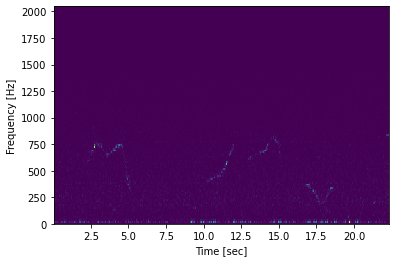

In [3]:
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile

# The wav file used here is a bowhead "slam dunk" sample
sample_rate, samples = wavfile.read('AU-AWBF02-121025-010844-30-MAW-bowhead-song.wav')
frequencies, times, spectrogram = signal.spectrogram(samples, sample_rate)

plt.pcolormesh(times, frequencies, spectrogram)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

The bowhead call can be seen clearly in the above plot as the *M* shaped curves


